In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import preprocessing

import warnings
warnings.filterwarnings('ignore')


#### Training set has 48 columns, while test set has 24 columns. The last 24 training columns are missing in the test data set!
- The first column (fecha_dato) is the date column. The second column (ncodpers) is the customer_id. 
- The third column (ind_empleado) is the status of employment; The fourth column (pais_residencia) is country of residency
- The fifth column (sexo) is sex; The six column (age); The seventh column (fecha_alta) is the date of join
- The eightth column (ind_nuevo) is new costumer; The ninth column (antiguedad) is antiquity (Senority 古老,古代)

['2015-01-28T00:00:00.000000000' '2016-06-28T00:00:00.000000000']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400000 entries, 0 to 399999
Data columns (total 12 columns):
fecha_dato               400000 non-null datetime64[ns]
ncodpers                 400000 non-null int64
age                      398063 non-null float64
fecha_alta               398063 non-null datetime64[ns]
ind_nuevo                398063 non-null float64
antiguedad               398063 non-null float64
indrel                   398063 non-null float64
indrel_1mes              398063 non-null float64
tipodom                  398063 non-null float64
cod_prov                 397409 non-null float64
ind_actividad_cliente    398063 non-null float64
renta                    327379 non-null float64
dtypes: datetime64[ns](2), float64(9), int64(1)
memory usage: 36.6 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400000 entries, 0 to 399999
Data columns (total 12 columns):
ind_empleado       398063 non-null ob

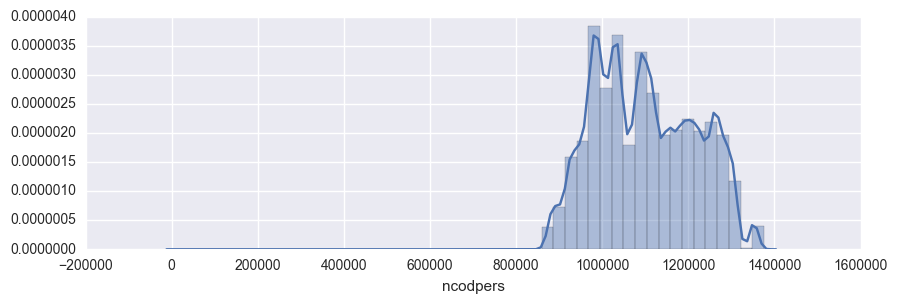

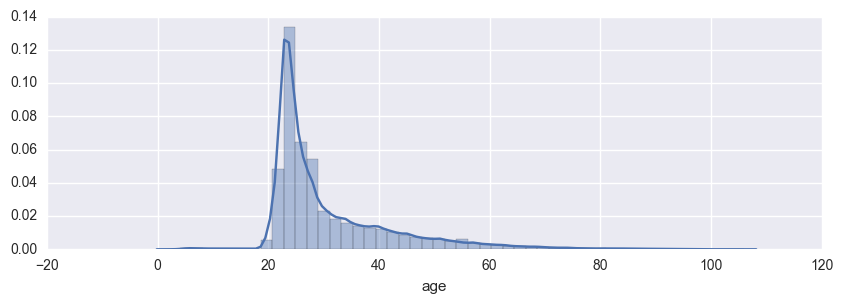

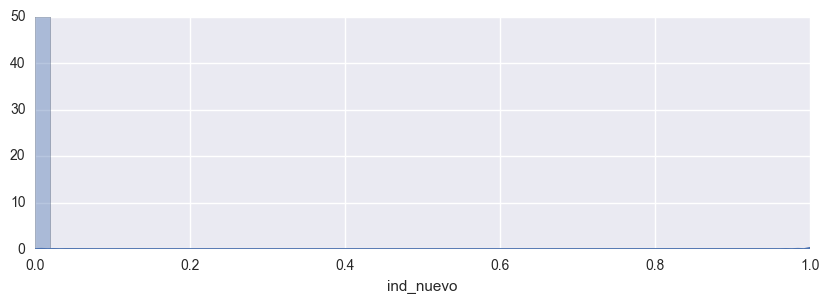

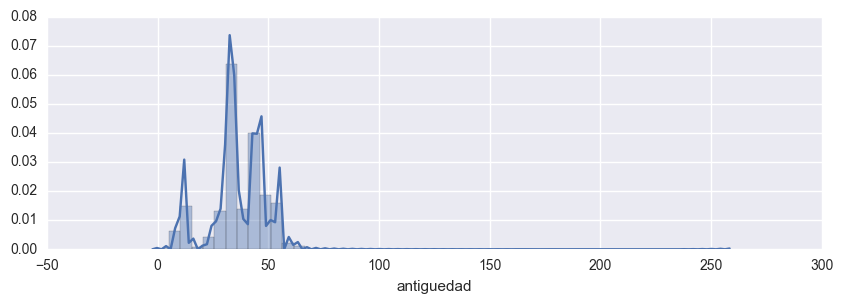

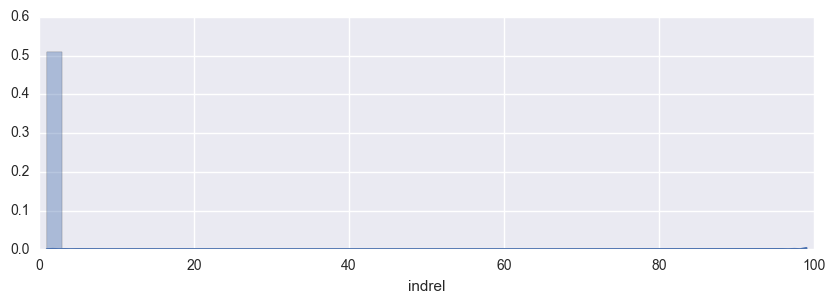

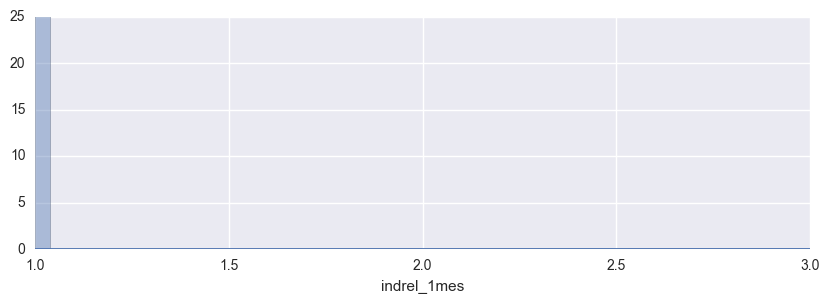

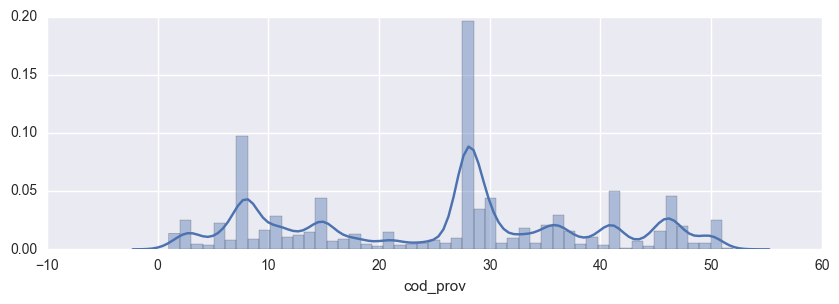

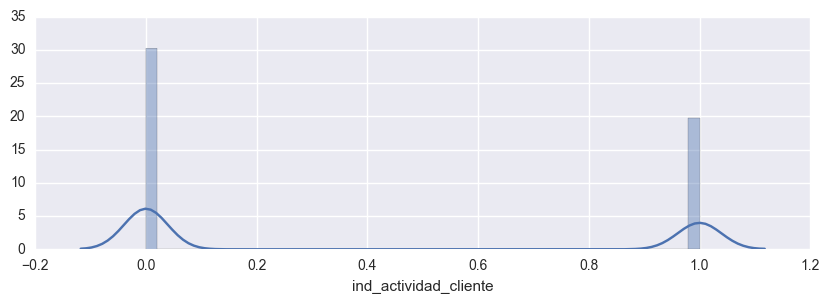

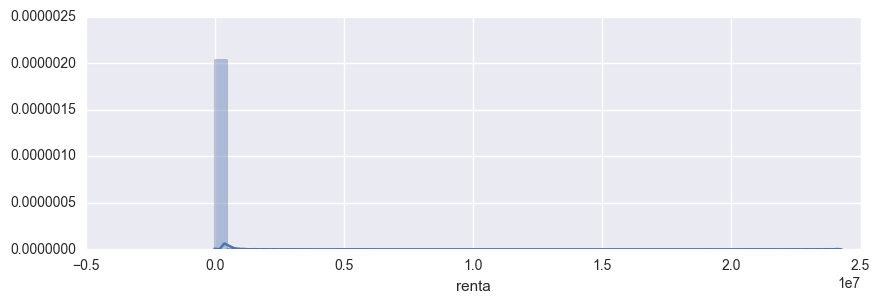

In [2]:
# read in data first
import os, math, time

os.chdir(r"J:\Tutorial\Kaggle Competitions\Santander")

train = pd.read_csv("train_ver2.csv", nrows=200000)
test = pd.read_csv('test_ver2.csv', nrows=200000)

# read in data first
#train = pd.read_csv("data/train_ver2.csv", nrows=200000)
#test = pd.read_csv('data/test_ver2.csv', nrows=200000)
#print(train.info())
#print(test.info())
#print(train.head())
#print(test.head())

# sepatate last 24 columns from training dataset
trainX = train.iloc[:,:24]
trainZ = train.iloc[:,24:]

# combine train and test dataset
combined = pd.concat([trainX, test], ignore_index=True)

# here 'age', 'renta' and 'antiguedad' are type of object, we need to convert it to numeric
# test's 'renta' is an object, so the final combined 'renta' is also type of object
combined['age']        = pd.to_numeric(combined['age'], errors='coerce')
combined['renta']      = pd.to_numeric(combined['renta'], errors='coerce')
combined['antiguedad'] = pd.to_numeric(combined['antiguedad'], errors='coerce')

# need to convert 'fecha_dato' and 'fecha_alta' to datetime
combined['fecha_dato'] = pd.to_datetime(combined['fecha_dato'], format='%Y-%m-%d')
combined['fecha_alta'] = pd.to_datetime(combined['fecha_alta'], format='%Y-%m-%d')
print(combined['fecha_dato'].unique())

# After all the above, you will find that we have nan in 'age' and 'fecha_alta'


# separate numeric columns from object (categorical) columns
combined_num = combined.select_dtypes(exclude=['object'])
combined_cat = combined.select_dtypes(include=['object'])
print(combined_num.info())
print(combined_cat.info())

# the 'conyuemp' column is empty at 100000, so remove it
combined_cat.drop('conyuemp', 1, inplace=True)

# tipodom doesn't seem to be useful, so I am going to drop it
combined_num.drop('tipodom', 1, inplace=True)

# As 99% of 'ult_fec_cli_1t' information missing, so I am going to drop it
combined_cat.drop('ult_fec_cli_1t', 1, inplace=True)

# as we have both cod_prov and nomprov, they represent the same thing. so drop nomprov
combined_cat.drop('nomprov', 1, inplace=True)

from collections import Counter
for col in combined_num.columns.values:
    if col == 'conyuemp':
        print(Counter(combined_num[col].dropna()))

# check data distributions
col_names = combined_num.columns

for i in range(1,11):
    #fig, axes = plt.subplots(nrows=1, ncols=1, sharey=False, figsize=(8,3))
    if i != 3:
        fig = plt.figure(figsize=(10,3))
        sns.distplot(combined_num[col_names[i]].dropna(), bins=50)
        plt.show()


### Handle Missing Data

In [3]:
# check to see if any of the columns has missing values and how many for each column
# if there are missing values, we might need to impute/fill-in those missing values
no_nan_cols = []
for col, val in combined.isnull().any().items():
    if val == True:
        print("number of nan for column ", col, " is: ", combined[col].isnull().sum())
        pass
    else:
        no_nan_cols.append(col)
        pass
print("these columns has no nan values in them", no_nan_cols)

number of nan for column  ind_empleado  is:  1937
number of nan for column  pais_residencia  is:  1937
number of nan for column  sexo  is:  1937
number of nan for column  age  is:  1937
number of nan for column  fecha_alta  is:  1937
number of nan for column  ind_nuevo  is:  1937
number of nan for column  antiguedad  is:  1937
number of nan for column  indrel  is:  1937
number of nan for column  ult_fec_cli_1t  is:  399453
number of nan for column  indrel_1mes  is:  1937
number of nan for column  tiprel_1mes  is:  1937
number of nan for column  indresi  is:  1937
number of nan for column  indext  is:  1937
number of nan for column  conyuemp  is:  399999
number of nan for column  canal_entrada  is:  1956
number of nan for column  indfall  is:  1937
number of nan for column  tipodom  is:  1937
number of nan for column  cod_prov  is:  2591
number of nan for column  nomprov  is:  2591
number of nan for column  ind_actividad_cliente  is:  1937
number of nan for column  renta  is:  72621
num

#### For age, the missing are NA at the origin dataset
- replace nan with mean() value

In [4]:
print("Find the number of nan in age: ", combined_num.age.isnull().sum())

print("Mean of age is; ", int(combined_num.age.mean()))
combined_num.age.fillna(int(combined_num.age.mean(skipna=True)), inplace=True)

print("Check if any nan left: ", combined_num.age.isnull().sum())

Find the number of nan in age:  1937
Mean of age is;  30
Check if any nan left:  0


#### For fecha_alta (join date)
- Some entries don't have the date they joined the company. Just give them something in the middle of the pack

In [5]:
dates=combined_num.loc[:,"fecha_alta"].sort_values().reset_index()
median_date = int(np.median(dates.index.values))
combined_num.loc[combined_num.fecha_alta.isnull(),"fecha_alta"] = dates.loc[median_date,"fecha_alta"]
#combined_num["fecha_alta"].describe()
print("Check for any nan left: ", combined_num.fecha_alta.isnull().sum())

Check for any nan left:  0


#### for ind_nuevo (New customer), need to find out more info

In [6]:
# find out how many nan for ind_neuvo
print("The total nan in ind_nuevo is ", combined_num['ind_nuevo'].isnull().sum())

# for ind_nuevo: from graph, it is binary. let's find out using Counter()
print(Counter(combined_num['ind_nuevo'].dropna()))

The total nan in ind_nuevo is  1937
Counter({0.0: 397565, 1.0: 498})


#### From distribution graph, ind_nuevo is binary. >95% of values are 0.0, so we will try to find out their history

In [7]:
history = combined_num.loc[combined_num['ind_nuevo'].isnull(),:].groupby("ncodpers", sort=False).size()
print(max(history))

1


In [8]:
#### they all new customers. So set the value to 1
combined_num['ind_nuevo'].fillna(1.0, inplace=True)

# comnined_num.loc[combined_num['ind_neuvo'].isnull(), 'ind_neuvo'] = 1.0
print(combined_num['ind_nuevo'].isnull().any())

False


#### for antiguedad (antiquity or Seniority)

In [9]:
print("how many contains nan for antiquity: ", combined_num['antiguedad'].isnull().sum())

# find out the most common one
print(Counter(combined_num['antiguedad'].dropna()))

# it seems the number of nan in antiguedad is the same as ind_nuevo
# Probably the same people that we just determined were new customers. Double check
combined_num.loc[combined_num['antiguedad'].isnull(), 'ind_nuevo'].describe()

# yes, same people as they all nan. Let's give them minimum seniority. or 25% percentile
print(combined_num['antiguedad'].dropna().describe())
twenty_five = np.percentile(combined_num['antiguedad'].dropna(), 25)
print("twenty five is ", twenty_five)

# the 25 percentile is 14
combined_num['antiguedad'].fillna(twenty_five, inplace=True)
print("check if any nan left in antiguedad: ", combined_num['antiguedad'].isnull().any())


how many contains nan for antiquity:  1937
Counter({32.0: 34112, 33.0: 28218, 34.0: 27124, 35.0: 23050, 44.0: 21643, 47.0: 21237, 12.0: 18701, 43.0: 17976, 31.0: 17280, 46.0: 16414, 55.0: 14879, 45.0: 14499, 36.0: 14005, 54.0: 9852, 48.0: 8115, 30.0: 7989, 10.0: 7643, 42.0: 6284, 29.0: 6140, 11.0: 5670, 27.0: 4969, 41.0: 4694, 8.0: 4588, 28.0: 4486, 38.0: 3972, 40.0: 3565, 37.0: 3555, 24.0: 3505, 49.0: 3237, 26.0: 3219, 39.0: 3026, 25.0: 2996, 52.0: 2937, 50.0: 2928, 51.0: 2738, 56.0: 2630, 13.0: 2501, 53.0: 2501, 14.0: 2205, 23.0: 1777, 62.0: 1418, 15.0: 1364, 61.0: 1260, 16.0: 954, 59.0: 886, 63.0: 793, 58.0: 763, 57.0: 716, 60.0: 707, 18.0: 448, 9.0: 229, 21.0: 213, 7.0: 199, 20.0: 180, 19.0: 166, 22.0: 144, 17.0: 134, 6.0: 129, 5.0: 115, 4.0: 96, 1.0: 93, 3.0: 89, 2.0: 82, 0.0: 21, 256.0: 1, 186.0: 1, 157.0: 1, 150.0: 1})
count    398063.000000
mean         36.237608
std          12.070321
min           0.000000
25%          32.000000
50%          35.000000
75%          45.000000
m

#### now for 'indrel' column, which indicates
- 1 (First/Primary), 99 (Primary customer during the month but not at the end of the month)

In [10]:
# find out how many rows are nan
print(combined_num['indrel'].isnull().sum())

# find out the most common count information
print(Counter(combined_num['indrel'].dropna()))

# fill in with most common one here
combined_num['indrel'].fillna(1.0, inplace=True)

print("Checking to see if the column has no more nan: ", combined_num['indrel'].isnull().any())

1937
Counter({1.0: 397516, 99.0: 547})
Checking to see if the column has no more nan:  False


#### now for 'indrel_1mes' column

In [11]:
# find out how many rows contain nan
print(combined_num['indrel_1mes'].isnull().sum())

# find out the most common count info
print(Counter(combined_num['indrel_1mes'].dropna()))
print(combined_num.indrel_1mes.unique())

# fill in with the most common one here
combined_num['indrel_1mes'].fillna(1.0, inplace=True)
print("Check to see if there is any nan left: ", combined_num['indrel_1mes'].isnull().any())

1937
Counter({1.0: 398052, 3.0: 11})
[  1.  nan   3.]
Check to see if there is any nan left:  False


#### for tipodom: (Addres type. 1, primary address)
- tipodom doesn't seem to be useful, so I am going to drop it, as it doesn't provide any useful information!

In [12]:
# find out how many in there
#print(combined_num['tipodom'].isnull().sum())

# find out the most commone one
#print(Counter(combined_num['tipodom'].dropna()))

# drop it
#combined_num['tipodom'].fillna(1.0, inplace=True)
#print("Check to see if there is still any nan left: ", combined_num['tipodom'].isnull().any())

#### for cod_prov: provincial code for the address
- it seems that nom_prov is the name of the provincial. So they are redundant. We only need one of them.
- the nom_prov will be removed!!!

In [13]:
# find out how many are nan
print("number of nan is ", combined_num['cod_prov'].isnull().sum())

# find out how many 'nom_prov' is nan
#print("number of nan for nom_prov is: ", combined_cat['nomprov'].isnull().sum())

# to see if they are the same entries
train.loc[train['cod_prov'].isnull(), 'nomprov'].describe()
prov = train[['cod_prov', 'nomprov']]
#print(prov[prov['cod_prov'].isnull()])

# find out the unique values in cod_prov
print(combined_num['cod_prov'].unique())

# set the nan to 0 
combined_num['cod_prov'].fillna(0, inplace=True)
print(combined_num['cod_prov'].unique())

number of nan is  2591
[ 29.  13.  50.  45.  24.  20.  10.  17.  49.   8.  37.   9.  22.  31.   5.
  40.  27.  25.  28.   3.  42.  41.  39.   7.  47.  36.  46.  44.  15.  32.
  23.  16.  48.  12.  26.   2.   6.  30.  11.  nan   4.  19.  34.  35.  14.
  21.  18.  33.  38.  52.  43.   1.  51.]
[ 29.  13.  50.  45.  24.  20.  10.  17.  49.   8.  37.   9.  22.  31.   5.
  40.  27.  25.  28.   3.  42.  41.  39.   7.  47.  36.  46.  44.  15.  32.
  23.  16.  48.  12.  26.   2.   6.  30.  11.   0.   4.  19.  34.  35.  14.
  21.  18.  33.  38.  52.  43.   1.  51.]


#### ind_actividad_cliente  (Ind_activity customer)
- from the data distribution, it is binary

In [14]:
print("Total number of nan is: ", combined_num['ind_actividad_cliente'].isnull().sum())

print("Find out the most common ones: ", Counter(combined_num['ind_actividad_cliente'].dropna()))

# need more time and reading, but right now, I will use the median
#print("Median value is: ", combined_num['ind_actividad_cliente'].dropna().mean())

combined_num['ind_actividad_cliente'].fillna(0.5, inplace=True)

print("Find out the most common ones: ", Counter(combined_num['ind_actividad_cliente'].dropna()))


Total number of nan is:  1937
Find out the most common ones:  Counter({0.0: 240980, 1.0: 157083})
Find out the most common ones:  Counter({0.0: 240980, 1.0: 157083, 0.5: 1937})


#### renta (rental)
- Here is a feature that is missing a lot of values. Rather than just filling them in with a median, it's probably more accurate to break it down region by region. To that end, let's take a look at the median income by region, and in the spirit of the competition let's color it like the Spanish flag.

In [15]:
print("Number of nan: ", combined_num['renta'].isnull().sum())

# from distribution, they are mostly close to the lower end
#print("The count info: ", combined_num['renta'].dropna().describe())

# group them by provincial code and find out the median of each one
#ave_rental = combined_num['renta'].dropna().groupby(combined_num['cod_prov']).describe()
ave_rental = combined_num['renta'].dropna().groupby(combined_num['cod_prov']).mean()
ave_rental = dict(ave_rental)
#print("The average rentals are: ", type(ave_rental))
#print(ave_rental.keys())

index = combined_num[combined_num['renta'].isnull()].index.tolist()
#print("The length of index is ", len(index))

# loop through is too slow, we have to do it python way
# rental_keys = ave_rental.keys()
#for idx in index:
#    prov_code = combined_num.ix[idx, 'cod_prov']
#    if prov_code in rental_keys:
#        combined_num.ix[idx, 'renta'] = ave_rental[prov_code]

# python way:
for pcode in ave_rental.keys():
    # fetch rows that are within the pcode and with 'renta' value is np.nan
    idx = combined_num.loc[combined_num.cod_prov.isin([pcode]) & combined_num.renta.isnull(), 'renta'].index.tolist()
    if idx:
        #print(idx)
        combined_num.ix[idx, 'renta'] = ave_rental[pcode]
    
print("Number of nan: ", combined_num['renta'].isnull().sum())
#print(combined_num[['cod_prov', 'renta']],)


Number of nan:  72621
Number of nan:  0


-The next columns with missing data I'll look at are features, which are just a boolean indicator as to whether or not that product was owned that month. Starting with ind_nomina_ult1..

In [16]:
# for ind_nomina_ult1, This column is not available at the test dataset, so I will update training data only
print("The number of missing data is: ", train.ind_nomina_ult1.isnull().sum())

print("Find out how many unique values in this column: ", Counter(train.ind_nomina_ult1.dropna()))

# I could try to fill in missing values for products by looking at previous months, 
# but since it's such a small number of values for now I'll take the cheap way out, using most common one ==> 0.0
train.loc[train.ind_nomina_ult1.isnull(), 'ind_nomina_ult1'] = 0.0

print("Check to see if there is any nan left: ", train.ind_nomina_ult1.isnull().sum())

The number of missing data is:  670
Find out how many unique values in this column:  Counter({0.0: 192485, 1.0: 6845})
Check to see if there is any nan left:  0


- The same could be true for ind_nom_pens_ult1

In [17]:
print("The number of missing values is: ", train.ind_nom_pens_ult1.isnull().sum())

print("The unique cout information: ", Counter(train.ind_nom_pens_ult1.dropna()))

train.loc[train.ind_nom_pens_ult1.isnull(), 'ind_nom_pens_ult1'] = 0

print("Check to see if any nan left: ", train.ind_nom_pens_ult1.isnull().sum())

The number of missing values is:  670
The unique cout information:  Counter({0.0: 191947, 1.0: 7383})
Check to see if any nan left:  0


### For categorical columns:
- based on that and the definitions of each variable, I will fill the empty strings either with the most common value or create an unknown category based on what I think makes more sense.
- For the most part, entries with NA will be converted to an unknown category.

#### For ind_empleado (employed or employment)
- fill-in with the most common one

In [18]:
print("The number of missing values is: ", combined_cat.ind_empleado.isnull().sum())

print("Find out the count information: ", Counter(combined_cat.ind_empleado.dropna()))

# fill-in with the most common one, that is 'N'
combined_cat.loc[combined_cat.ind_empleado.isnull(), 'ind_empleado'] = 'N'

print("Check to see if there is any nan left: ", combined_cat.ind_empleado.isnull().sum())

The number of missing values is:  1937
Find out the count information:  Counter({'N': 398060, 'A': 2, 'F': 1})
Check to see if there is any nan left:  0


#### For pais_residencia (Country of residency)
- fill-in with the most common one

In [19]:
print("Find the number of missing values: ", combined_cat.pais_residencia.isnull().sum())

print("Find the count information: ", Counter(combined_cat.pais_residencia.dropna()))

# fill-in with the most common one that is 'ES'
combined_cat.loc[combined_cat.pais_residencia.isnull(), 'pais_residencia'] = 'ES'

print("Check to see if there is any nan left: ", combined_cat.pais_residencia.isnull().sum())

Find the number of missing values:  1937
Find the count information:  Counter({'ES': 397409, 'IT': 91, 'MX': 63, 'CO': 52, 'GB': 47, 'DE': 44, 'FR': 43, 'BR': 34, 'CN': 25, 'US': 23, 'CH': 20, 'RO': 20, 'PE': 17, 'AR': 14, 'PT': 13, 'BE': 12, 'PL': 10, 'MA': 9, 'VE': 8, 'CL': 8, 'IE': 7, 'HN': 7, 'RU': 6, 'EC': 5, 'AT': 5, 'NO': 5, 'GT': 4, 'NL': 4, 'FI': 4, 'DO': 4, 'IN': 3, 'SE': 3, 'GR': 3, 'EE': 2, 'CZ': 2, 'PY': 2, 'NI': 2, 'UA': 2, 'BG': 2, 'SN': 2, 'GA': 2, 'AE': 2, 'MR': 2, 'IL': 2, 'CM': 2, 'CA': 2, 'CR': 1, 'LT': 1, 'SA': 1, 'AD': 1, 'PR': 1, 'JP': 1, 'QA': 1, 'DJ': 1, 'LU': 1, 'MZ': 1, 'AL': 1, 'ET': 1, 'TW': 1, 'SV': 1, 'HK': 1})
Check to see if there is any nan left:  0


#### For sexo
- use unknown category

In [20]:
print("Find how many is nan: ", combined_cat.sexo.isnull().sum())

print("Get the count information\\\: ", Counter(combined_cat.sexo.dropna()))

combined_cat.loc[combined_cat.sexo.isnull(), 'sexo'] = 'U'

print("Check if any nan left:  ", combined_cat.sexo.isnull().sum())

Find how many is nan:  1937
Get the count information\\:  Counter({'H': 207583, 'V': 190480})
Check if any nan left:   0


#### for ult_fec_cli_1t

In [21]:
#print("Find how many nan in ult_fec_cli_1t: ", combined_cat.ult_fec_cli_1t.isnull().sum())

#print("Find the count information: ", Counter(combined_cat.ult_fec_cli_1t.dropna()))

# this is a date information and no most common one, we might have to set it with an unknown
# As 99% of data miss this information. I am going to drop it!

#### For indfall
- use the most common one 'N'

In [22]:
print("Find how many nan in this column: ", combined_cat.indfall.isnull().sum())

print("Find the most common one: ", Counter(combined_cat.indfall.dropna()))

# fill-in with the most common one
combined_cat.loc[combined_cat.indfall.isnull(), 'indfall'] = 'N'

print("Check to see if any nan left: ", combined_cat.indfall.isnull().sum())

Find how many nan in this column:  1937
Find the most common one:  Counter({'N': 397946, 'S': 117})
Check to see if any nan left:  0


#### For tiprel_1mes

In [23]:
print("Find out how many nan in this column: ", combined_cat.tiprel_1mes.isnull().sum())

print("Find out the most common one; ", Counter(combined_cat.tiprel_1mes.dropna()))

# fill-in with an unknown 'U'
combined_cat.loc[combined_cat.tiprel_1mes.isnull(), 'tiprel_1mes'] = 'U'

print("Check to see if any nan left: ", combined_cat.tiprel_1mes.isnull().sum())

Find out how many nan in this column:  1937
Find out the most common one;  Counter({'I': 252008, 'A': 146044, 'P': 11})
Check to see if any nan left:  0


#### For indresi
- fill-in with the most commone one, 'S'

In [24]:
print("Find how many nan: ", combined_cat.indresi.isnull().sum())

print("Get the count information: ", Counter(combined_cat.indresi.dropna()))

combined_cat.loc[combined_cat.indresi.isnull(), 'indresi'] = 'S'

print("Check to see if any nan left: ", combined_cat.indresi.isnull().sum())

Find how many nan:  1937
Get the count information:  Counter({'S': 397409, 'N': 654})
Check to see if any nan left:  0


#### For indext
- fill-in with the most common one

In [25]:
print("Find out how many nan in this column: ", combined_cat.indext.isnull().sum())

print("Get count information: ", Counter(combined_cat.indext.dropna()))

combined_cat.loc[combined_cat.indext.isnull(), 'indext'] = 'N'

print("Check to see if any nan left: ", combined_cat.indext.isnull().sum())

Find out how many nan in this column:  1937
Get count information:  Counter({'N': 378899, 'S': 19164})
Check to see if any nan left:  0


#### For canal_entrada (input channel)

In [26]:
print("Find how many nans: ", combined_cat.canal_entrada.isnull().sum())

print("Find the most common one: ", Counter(combined_cat.canal_entrada.dropna()))

# fill-in with the most common one, 'KHE'
combined_cat.loc[combined_cat.canal_entrada.isnull(), 'canal_entrada'] = 'KHE'

print("Check to see if any nan left: ", combined_cat.canal_entrada.isnull().sum())

Find how many nans:  1956
Find the most common one:  Counter({'KHE': 260858, 'KFC': 78878, 'KAT': 33968, 'KHD': 8653, 'KFA': 6681, 'RED': 2298, 'KAZ': 1262, 'KHK': 1059, 'KHC': 747, 'KHF': 496, 'KHN': 476, 'KHM': 397, 'KAG': 159, 'KAE': 140, 'KAR': 139, 'KFD': 132, 'KAA': 128, 'KHL': 121, 'KAQ': 111, 'KAB': 105, 'KFP': 102, 'KBG': 96, 'KHQ': 95, 'KGX': 92, 'KCC': 85, 'KEH': 77, 'KGV': 67, 'KAH': 67, 'KAI': 63, 'KFG': 60, 'KFJ': 54, 'KFF': 49, 'KHO': 45, 'KFS': 44, 'KAJ': 38, 'KFU': 38, 'KFL': 36, 'KFN': 29, 'KAP': 26, 'KFK': 26, 'KGY': 25, 'KDH': 6, 'KHA': 3, 'KAK': 3, 'KAD': 2, 'KGC': 2, 'KAF': 1, '013': 1, 'K00': 1, 'KDE': 1, 'KFV': 1, 'KGN': 1})
Check to see if any nan left:  0


#### For segmento (segment)

In [27]:
print("Find how many nans: ", combined_cat.segmento.isnull().sum())

print("Find the most common one: ", Counter(combined_cat.segmento.dropna()))

# fill-in with the most common one, as the new costomers are unlikely to be at the top
combined_cat.loc[combined_cat.segmento.isnull(), 'segmento'] = 'UNIVERSITARIO'

print("Check to see if any nans left: ", combined_cat.segmento.isnull().sum())

Find how many nans:  1965
Find the most common one:  Counter({'03 - UNIVERSITARIO': 270897, '02 - PARTICULARES': 121331, '01 - TOP': 5807})
Check to see if any nans left:  0


In [28]:
# now left see if any nan left in the entire dataset
#del combined

print(combined_num.isnull().any())
print(combined_cat.isnull().any())
#combined = pd.concat([combined_num, combined_cat])
#combined.isnull().any()

fecha_dato               False
ncodpers                 False
age                      False
fecha_alta               False
ind_nuevo                False
antiguedad               False
indrel                   False
indrel_1mes              False
cod_prov                 False
ind_actividad_cliente    False
renta                    False
dtype: bool
ind_empleado       False
pais_residencia    False
sexo               False
tiprel_1mes        False
indresi            False
indext             False
canal_entrada      False
indfall            False
segmento           False
dtype: bool


In [29]:
print("nan in train age:  ", train.age.isnull().sum())
print("nan in test age:  ", test.age.isnull().sum())
print("nan in trainX age:  ", trainX.age.isnull().sum())
print("nan in combined age:  ", combined.age.isnull().sum())
print("nan in combined_num age:  ", combined_num.age.isnull().sum())

nan in train age:   0
nan in test age:   0
nan in trainX age:   0
nan in combined age:   1937
nan in combined_num age:   0


#### Now for the remaining 24 columns that are missing in test dataset

In [30]:
for col in trainZ.columns:
    print("The count information for ", col, ' is ', Counter(trainZ[col].dropna()))

The count information for  ind_ahor_fin_ult1  is  Counter({0: 200000})
The count information for  ind_aval_fin_ult1  is  Counter({0: 199999, 1: 1})
The count information for  ind_cco_fin_ult1  is  Counter({1: 177879, 0: 22121})
The count information for  ind_cder_fin_ult1  is  Counter({0: 199990, 1: 10})
The count information for  ind_cno_fin_ult1  is  Counter({0: 188710, 1: 11290})
The count information for  ind_ctju_fin_ult1  is  Counter({0: 198419, 1: 1581})
The count information for  ind_ctma_fin_ult1  is  Counter({0: 194224, 1: 5776})
The count information for  ind_ctop_fin_ult1  is  Counter({0: 199961, 1: 39})
The count information for  ind_ctpp_fin_ult1  is  Counter({0: 198818, 1: 1182})
The count information for  ind_deco_fin_ult1  is  Counter({0: 199799, 1: 201})
The count information for  ind_deme_fin_ult1  is  Counter({0: 199927, 1: 73})
The count information for  ind_dela_fin_ult1  is  Counter({0: 195113, 1: 4887})
The count information for  ind_ecue_fin_ult1  is  Counter({

### The targets (Labels)
- here trainZ is really the targets

In [37]:
target_cols = ['ind_ahor_fin_ult1','ind_aval_fin_ult1','ind_cco_fin_ult1','ind_cder_fin_ult1','ind_cno_fin_ult1',
               'ind_ctju_fin_ult1','ind_ctma_fin_ult1','ind_ctop_fin_ult1','ind_ctpp_fin_ult1','ind_deco_fin_ult1',
               'ind_deme_fin_ult1','ind_dela_fin_ult1','ind_ecue_fin_ult1','ind_fond_fin_ult1','ind_hip_fin_ult1',
               'ind_plan_fin_ult1','ind_pres_fin_ult1','ind_reca_fin_ult1','ind_tjcr_fin_ult1','ind_valo_fin_ult1',
               'ind_viv_fin_ult1','ind_nomina_ult1','ind_nom_pens_ult1','ind_recibo_ult1']
print(len(target_cols))
target_cols = target_cols[2:]
print(len(target_cols))

24
22
